#Booking.com: Where will a new guest book their first travel experience?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil.parser

In [2]:
#Read in data from folder with csv files
train_users = pd.read_csv("train_users_2.csv")  #this is the fixed data from kaggle (last 15 usrs had mistakes)
#age_gender_bkts = pd.read_csv("age_gender_bkts.csv")
#sessions = pd.read_csv("sessions.csv")
#countries = pd.read_csv("countries.csv")
test_users = pd.read_csv("test_users.csv")

After looking through the files, it seems that most relevant features are represented within the training data set. There may be potential new features we can derive from the countries* file but for sake of simplicity, we will work with just the training and test sets


*specifically levenshtein distance (edit distance)

In [3]:
print train_users.dtypes
print 
print test_users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking         float64
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signu

**Objectives** 

We're predicting **country_destination** for every **test user**.

Need a list of countries

So drop country_destination from train to use as labels. This equalizes the column names of the training and test set.

We will also need of all the ID's of the test users.

In [4]:
country_dests = train_users.country_destination.values #Labels

train_users = train_users.drop(['country_destination'],axis=1) 
test_ids = test_users.id #series of test ids

train_users.shape

(213451, 15)

In [5]:
#for retrieving training set
total_train_users = train_users.shape[0]

print "Train User Count:", total_train_users
print "Test User Count:", test_users.shape[0]
print train_users.dtypes

Train User Count: 213451
Test User Count: 62096
id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
dtype: object


As a note, it looks like there are date variables that are not date types. 

Before we do any manipulation of data, we're going to concatenate the test and training data. This way any features created in the training set will be reflected in the test set.

In [6]:
#Concatenating train and test data by rows
full_df = pd.concat((train_users, test_users), axis=0, ignore_index=True)

In [7]:
full_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


**Data Cleaning**

Preprocessing of the data:
    - drop irrelevant columns 
      (note: kaggle has removed 'date_first_booking' var)
    - deal with missing values
    - convert date values

In [8]:
#drop id an date_first_booking columns
full_df_processed = full_df.drop(['id', 'date_first_booking'], axis=1)

#fill in missing values nans
full_df_processed = full_df_processed.fillna(np.nan)

In [9]:
full_df_processed

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,2011-05-25,20090523174809,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,2010-09-28,20090609231247,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,2011-12-05,20091031060129,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,2010-09-14,20091208061105,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
5,2010-01-01,20100101215619,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome
6,2010-01-02,20100102012558,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari
7,2010-01-03,20100103191905,FEMALE,47,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari
8,2010-01-04,20100104004211,FEMALE,50,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari
9,2010-01-04,20100104023758,-unknown-,46,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox


**Feature engineering**

In [10]:
#date_account_created
dac = np.vstack(full_df_processed.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
full_df_processed['dac_year'] = dac[:,0]
full_df_processed['dac_month'] = dac[:,1]
full_df_processed['dac_day'] = dac[:,2]
full_df_processed = full_df_processed.drop(['date_account_created'], axis=1)

#timestamp_first_active
tfa = np.vstack(full_df_processed.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
full_df_processed['tfa_year'] = tfa[:,0]
full_df_processed['tfa_month'] = tfa[:,1]
full_df_processed['tfa_day'] = tfa[:,2]
full_df_processed = full_df_processed.drop(['timestamp_first_active'], axis=1)

#Age
age_vals = full_df_processed.age.values
full_df_processed['age'] = np.where(np.logical_or(age_vals<14, age_vals>100), -1, age_vals)

Take all the categorical variables and one hot encode them to effectively expand the feature space for each value within a variable.

In [11]:

#One-hot-encoding for all the categorical variables, in pandas it is get_dummies
onehot_features = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for features in onehot_features:
    dummy = pd.get_dummies(full_df_processed[features], prefix=features)
    full_df_processed = full_df_processed.drop([features], axis=1)
    full_df_processed = pd.concat((full_df_processed,dummy), axis=1)


In [13]:
full_df_processed.head()

,age,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,gender_MALE,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,NaN,2010,6,28,2009,3,19,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38,2011,5,25,2009,5,23,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,56,2010,9,28,2009,6,9,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,42,2011,12,5,2009,10,31,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,41,2010,9,14,2009,12,8,1,0,0,...,0,0,0,0,0,0,0,0,0,0


After we're done with the feature engineering, we have to do a test train split so we can start modelling. Here we separate the test set from the train set.

In [19]:
from sklearn.preprocessing import LabelEncoder

#Split train test
####X = full_df_processed.values[:total_train_users]
X = full_df_processed[:total_train_users]
le = LabelEncoder()
y = le.fit_transform(country_dests)

####X_test = full_df_processed.values[total_train_users:]
X_test = full_df_processed[total_train_users:]

X and X_test were originally using .values so that the headers would be numerical and plot_trees would work, but for the sake of human interpretability in the feature_importance, I've commented it out and used the X's with headers

**Xtreme Gradient Boost**

In [20]:
from xgboost.sklearn import XGBClassifier

xgb_model = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)

In [21]:
xgb_model.fit(X,y)
y_predict = xgb_model.predict_proba(X_test)


For submission, we'll take the 5 most probable countries per user. The kaggle challenge is using a NDCG (normalized discounted cumulative gain) algorithm that ranks the most relevant the highest and "discounting the gain" for the following guesses (or results in search engines)

In [16]:
ids = []  #list of ids
country_list = []  #list of countries
for i in range(len(test_ids)):
    idx = test_ids[i]
    ids += [idx] * 5
    #reverses the LabelEncoder back to human interpretable values. Here: countries
    country_list += le.inverse_transform(np.argsort(y_predict[i])[::-1])[:5].tolist()
    


**This generates the actual submission file**

In [32]:

booking.com_submission = pd.DataFrame(np.column_stack((ids, country_list)), columns=['id', 'country'])
booking.com_submission.to_csv('booking.com_sub.csv',index=False)

plot_importance provides us with the important features of the xgb_model. 

In [38]:
import xgboost as xgb

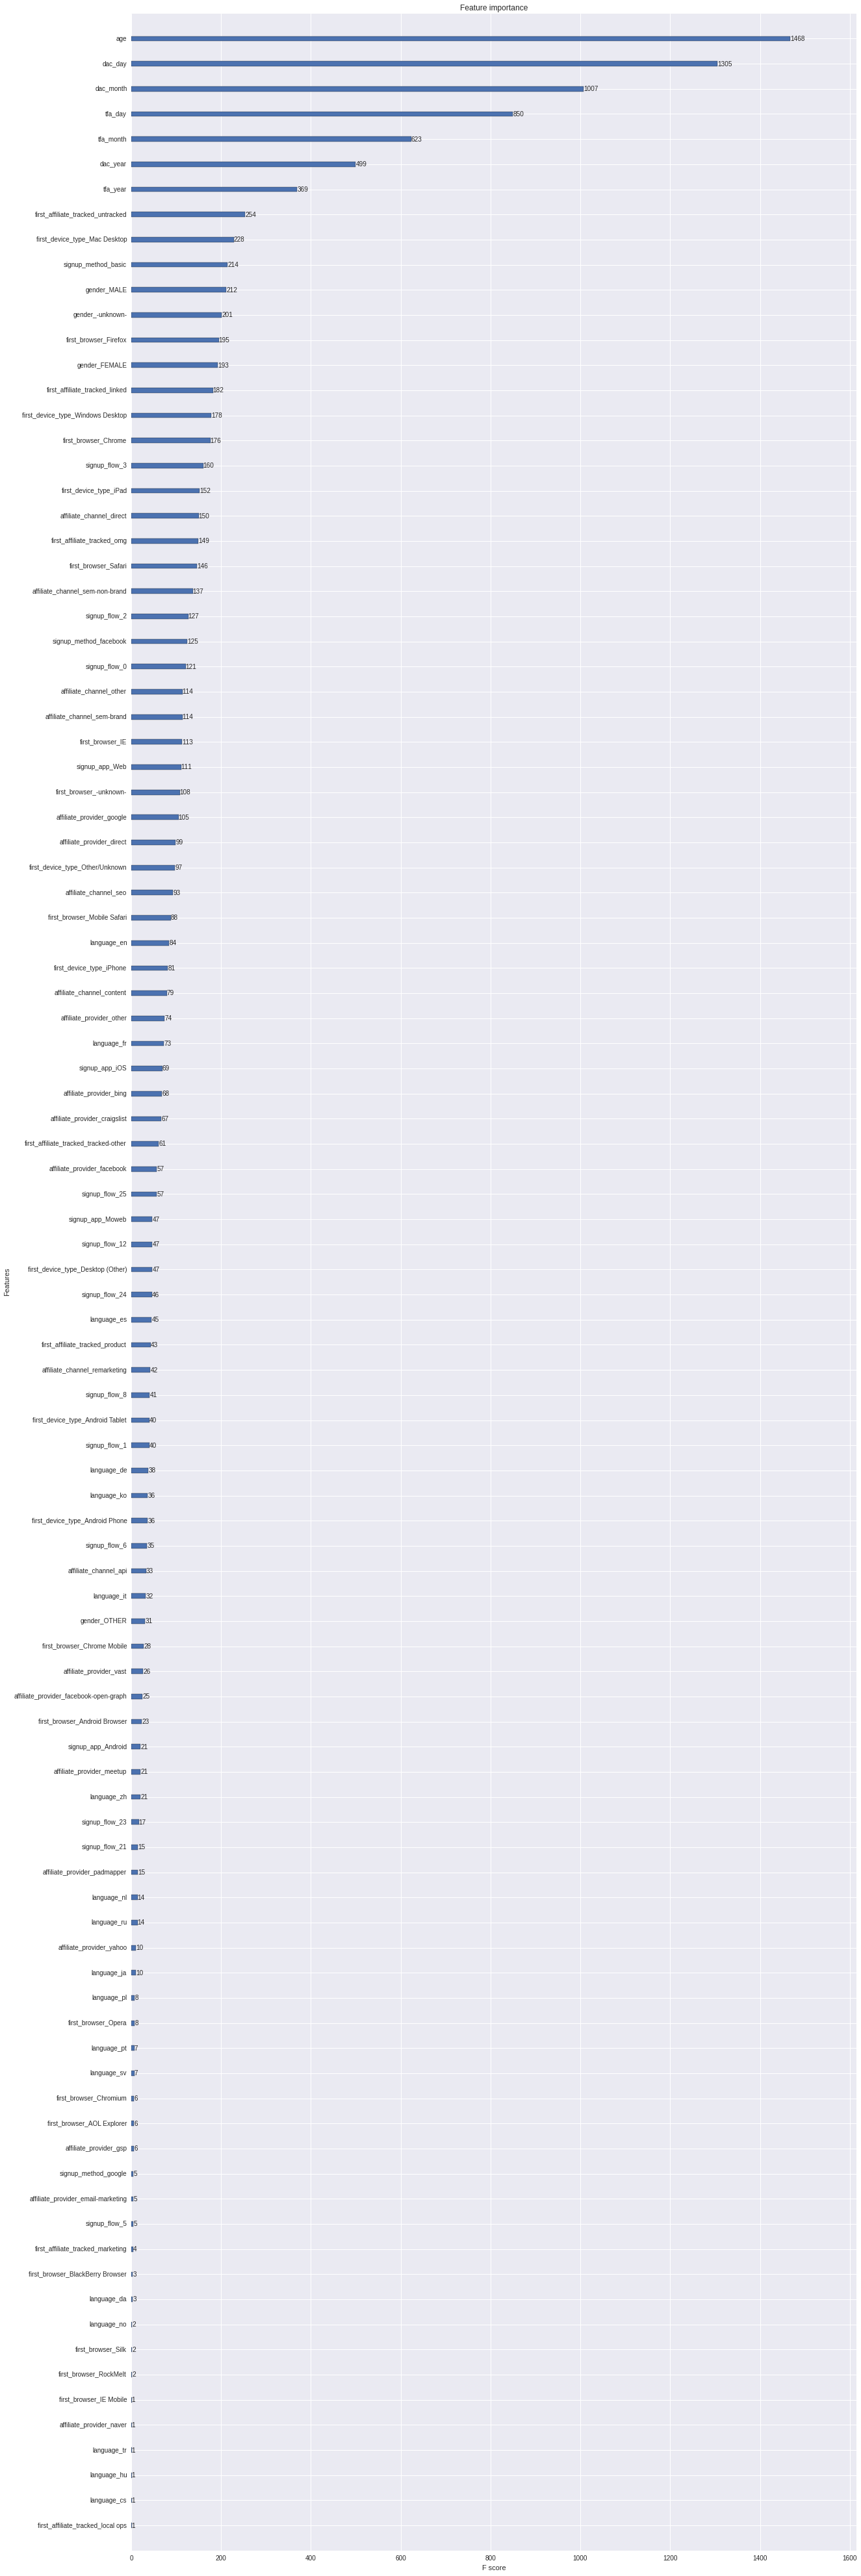

In [40]:
plt.rcParams['figure.figsize'] = (20, 70)
xgb.plot_importance(xgb_model)
plt.show()

ValueError: Unable to parse node: 0:[first_device_type_Mac

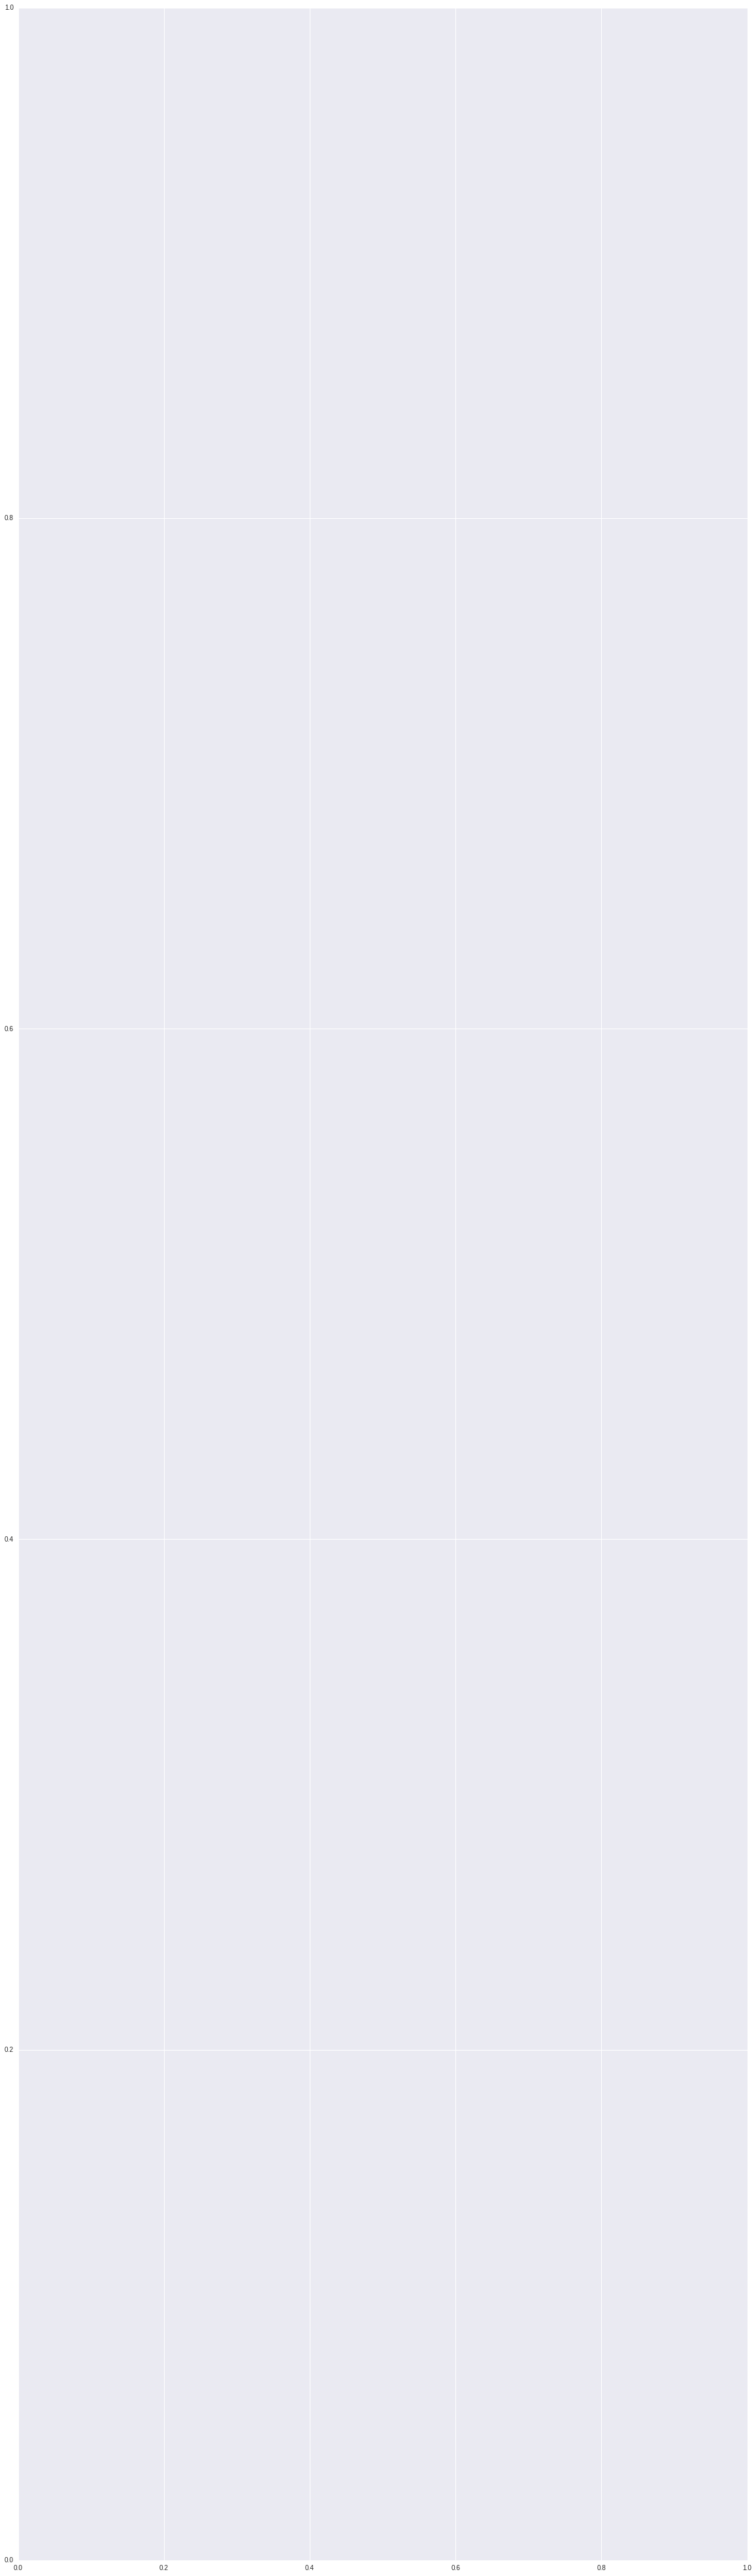

In [41]:
#plots the decision trees. note: need to go back to test train split and use .values for the headers to plot trees
xgb.plot_tree(xgb_model, num_trees=2)


The following is just random uncommented EDA. please igonore until commented and cleaned.

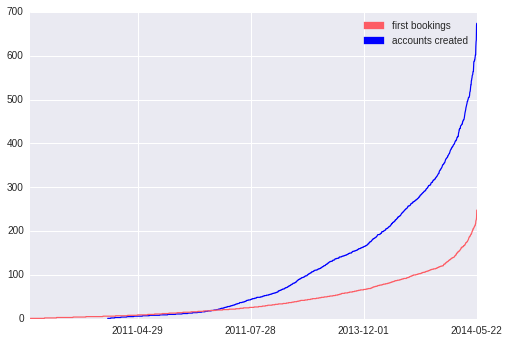

In [97]:
import matplotlib.patches as mpatches



train_users.date_account_created.value_counts().plot(kind='line', linewidth=1.2, color='#0000FF')
train_users.date_first_booking.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')
plt.gca().invert_xaxis()


red_patch = mpatches.Patch(color='#FD5C64', label='first bookings')
blue_patch = mpatches.Patch(color='#0000FF', label='accounts created')
plt.legend(handles=[red_patch,blue_patch])

plt.show()



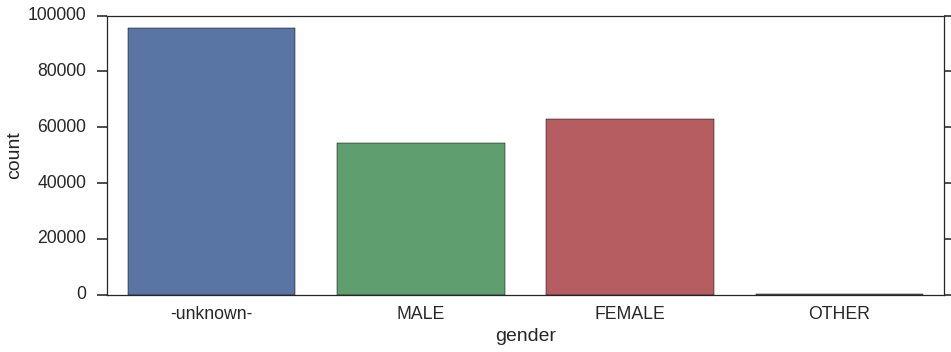

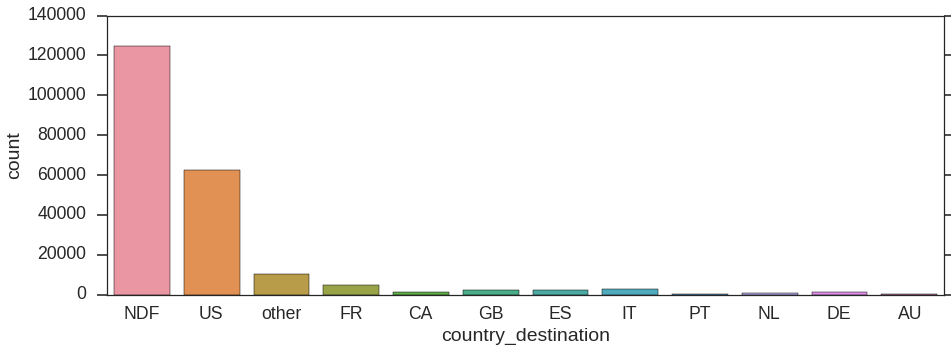

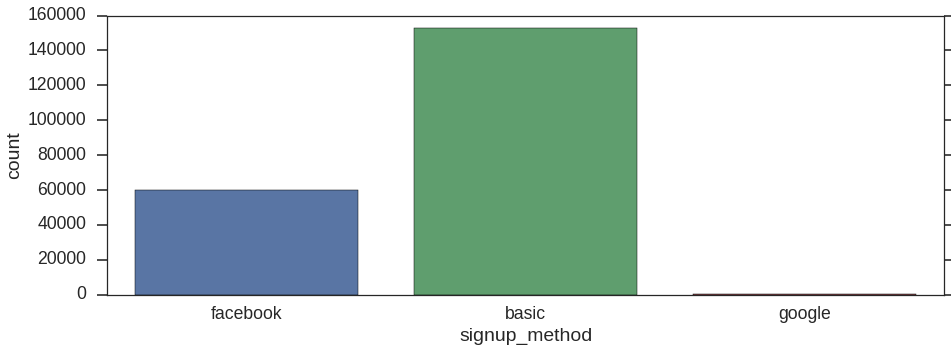

In [19]:
#train_users.ix[:,15]
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x = "gender", data = train_users, ax= axis1)
plt.show()

fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x = "country_destination", data = train_users, ax= axis1)
plt.show()
    
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x = "signup_method", data = train_users, ax= axis1)
plt.show()



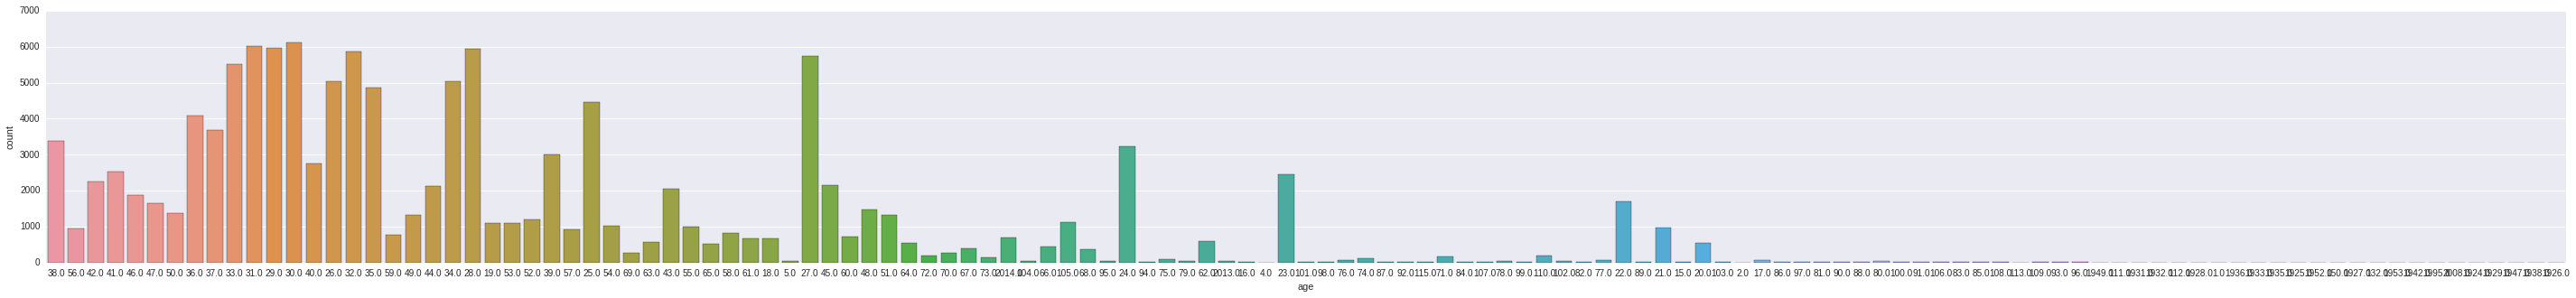

In [47]:
plt.rcParams['figure.figsize'] = (50, 5)

fig, (axis1) = plt.subplots(1,1)
sns.countplot(x = "age", data = train_users, ax= axis1)
plt.show()

In [9]:
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675,eng,0.00


In [24]:
train_users["first_device_type"].value_counts()

Mac Desktop           74890
Windows Desktop       60048
iPhone                12148
iPad                  11451
Other/Unknown          9938
Android Phone           951
Desktop (Other)         932
Android Tablet          828
SmartPhone (Other)       53
dtype: int64

In [27]:
y = train_users["country_destination"]
X = train_users.drop("country_destination", axis = 1)

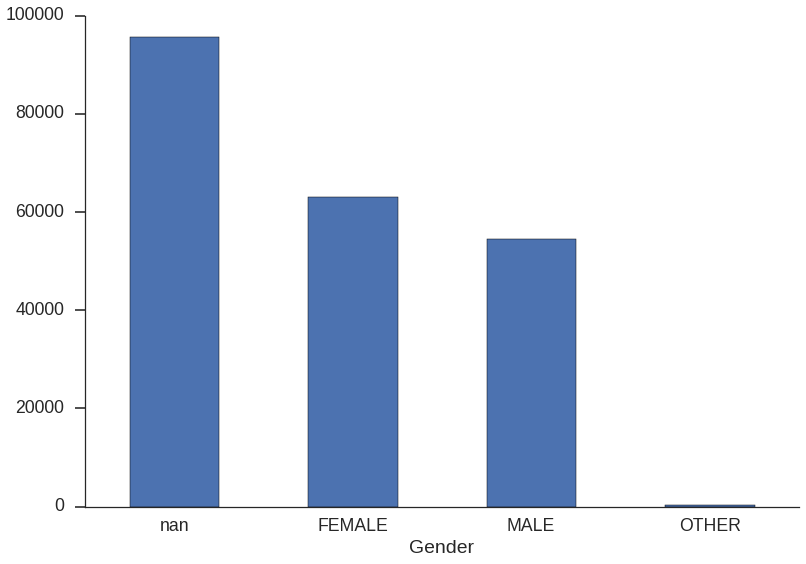

In [22]:

train_users.gender.replace('-unknown-',np.NaN).value_counts(dropna=False).plot(kind='bar', rot=0)
plt.xlabel('Gender')
sns.despine()

In [121]:
train_users.age <18 

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
213421    False
213422    False
213423    False
213424    False
213425    False
213426    False
213427    False
213428    False
213429    False
213430    False
213431    False
213432    False
213433    False
213434    False
213435    False
213436    False
213437    False
213438    False
213439    False
213440    False
213441    False
213442    False
213443    False
213444    False
213445    False
213446    False
213447    False
213448    False
213449    False
213450    False
Name: age, dtype: bool

In [142]:
print train_users[train_users.age > 100]['age'].count()
print train_users[train_users.age <18]['age'].count()


2345
158
